In [2]:
import requests
import pandas as pd
import selenium
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random


In [3]:
#pip install undetected_chromedriver

In [ ]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random
# Cambiar el user-agent para simular un navegador real
# El user-agent que tienes es de Chrome 114, pero tu Chrome es versión 137.
# Puedes actualizar el user-agent para que coincida con tu versión real de Chrome:


# Inicializar el navegador con undetected_chromedriver
# Ya estás usando undetected_chromedriver, que ayuda a evitar la detección.
# Además, puedes agregar opciones para hacer el navegador más "humano":

# options = uc.ChromeOptions()
# options.add_argument("--disable-blink-features=AutomationControlled")
# options.add_argument("--no-sandbox")
# options.add_argument("--disable-infobars")
# options.add_argument("--disable-extensions")
# options.add_argument("--profile-directory=Default")
# options.add_argument("--disable-plugins-discovery")
# options.add_argument("--start-maximized")
# options.add_argument("--disable-dev-shm-usage")
# user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.7151.120 Safari/537.36"
# options.add_argument(f"user-agent={user_agent}")

# Desactivar la automatización de Selenium en el navegador
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option("useAutomationExtension", False)
# options.add_argument("user_agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")

driver = uc.Chrome()  # options=options
df = pd.DataFrame(columns=["name", "price", "kms", "year", "cv", "url"])
try:
    # URL a scrapear
    url = "https://www.coches.net/search/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=282"  # "https://www.coches.net/search/?hasPhoto=false&wwa=false"
    driver.get(url)
    print("Página cargada con éxito")

    # Esperar a que la página cargue completamente
    time.sleep(random.uniform(5, 10))  # Pausa aleatoria entre 2 y 5 segundos

    # Buscar el botón por ID y hacer clic
    try:
        agree_button = driver.find_element(By.ID, "didomi-notice-agree-button")
        agree_button.click()
        print("Se hizo clic en el botón de aceptar cookies")
    except Exception as e:
        print(f"No se encontró el botón de aceptar cookies: {e}")

    # Esperar después de hacer clic
    time.sleep(random.uniform(2, 5))
    # Desplazar hasta el fondo de la página para cargar más contenido
    # Hacer scroll incrementalmente hasta que no se carguen más anuncios nuevos
    # Hacer un único barrido incremental de la página completa
    scroll_increment = 500
    last_height = driver.execute_script("return document.body.scrollHeight")
    current_position = 0
    while current_position < last_height:
        driver.execute_script(f"window.scrollTo(0, {current_position});")
        time.sleep(random.uniform(0.5, 1))
        current_position += scroll_increment
        # Actualizar last_height en caso de que se cargue más contenido dinámicamente
        last_height = driver.execute_script("return document.body.scrollHeight")
    # Asegurarse de llegar al final
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # time.sleep()

    time.sleep(random.uniform(2, 5))  # Esperar a que cargue el contenido adicional
    car_ads = driver.find_elements(By.CLASS_NAME, "mt-CardAd-infoContainer")

    for add in car_ads:
        try:
            # Buscar los elementos dentro de cada anuncio
            name = add.find_element(By.CLASS_NAME, "mt-CardAd-infoHeaderTitleLink").text
            price = add.find_element(By.CLASS_NAME, "mt-CardAdPrice-cashAmount").text
            
            # Obtener todos los atributos de la lista
            attributes = add.find_elements(By.CLASS_NAME, "mt-CardAd-attrItem")
            
            # Identificar los atributos por su posición en la lista
            fuel_type = attributes[0].text if len(attributes) > 0 else "N/A"
            year = attributes[1].text if len(attributes) > 1 else "N/A"
            kms = attributes[2].text if len(attributes) > 2 else "N/A"
            cv = attributes[3].text if len(attributes) > 3 else "N/A"
            location = attributes[4].text if len(attributes) > 4 else "N/A"

            # Agregar los datos al DataFrame
            df = pd.concat([df, pd.DataFrame([{
                "name": name,
                "price": price,
                "fuel_type": fuel_type,
                "year": year,
                "kms": kms,
                "cv": cv,
                "location": location
            }])], ignore_index=True)

        except Exception as e:
            print(f"Error al procesar un anuncio: {e}")

finally:
    # Cerrar el navegador
    print("Cerrando el navegador")
    driver.quit()

Página cargada con éxito
Se hizo clic en el botón de aceptar cookies
Cerrando el navegador


In [31]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random
# Cambiar el user-agent para simular un navegador real
# El user-agent que tienes es de Chrome 114, pero tu Chrome es versión 137.
# Puedes actualizar el user-agent para que coincida con tu versión real de Chrome:


# Inicializar el navegador con undetected_chromedriver
# Ya estás usando undetected_chromedriver, que ayuda a evitar la detección.
# Además, puedes agregar opciones para hacer el navegador más "humano":

# options = uc.ChromeOptions()
# options.add_argument("--disable-blink-features=AutomationControlled")
# options.add_argument("--no-sandbox")
# options.add_argument("--disable-infobars")
# options.add_argument("--disable-extensions")
# options.add_argument("--profile-directory=Default")
# options.add_argument("--disable-plugins-discovery")
# options.add_argument("--start-maximized")
# options.add_argument("--disable-dev-shm-usage")
# user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.7151.120 Safari/537.36"
# options.add_argument(f"user-agent={user_agent}")

# Desactivar la automatización de Selenium en el navegador
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option("useAutomationExtension", False)
# options.add_argument("user_agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")

driver = uc.Chrome()  # options=options
base_url = "https://www.coches.net/search/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=282&Versions%5B0%5D=&pg="
df = pd.DataFrame(columns=["name", "price", "fuel_type", "year", "kms", "cv", "location"])

page = 1  # Iniciar desde la página 1
while True:
    try:
        # Construir la URL de la página actual
        url = f"{base_url}{page}"
        driver.get(url)
        print(f"Cargando página {page}...")

        # Esperar a que la página cargue completamente
        time.sleep(random.uniform(5, 10))

        # Buscar el botón de aceptar cookies solo en la primera página
        if page == 1:
            try:
                agree_button = driver.find_element(By.ID, "didomi-notice-agree-button")
                agree_button.click()
                print("Se hizo clic en el botón de aceptar cookies")
            except Exception as e:
                print(f"No se encontró el botón de aceptar cookies: {e}")

        # Desplazar hasta el fondo de la página para cargar más contenido
        scroll_increment = 400
        last_height = driver.execute_script("return document.body.scrollHeight")
        current_position = 0
        while current_position < last_height:
            driver.execute_script(f"window.scrollTo(0, {current_position});")
            time.sleep(random.uniform(0.5, 1.2))
            current_position += scroll_increment
            last_height = driver.execute_script("return document.body.scrollHeight")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(random.uniform(2, 5))

        # Obtener los anuncios de la página actual
        car_ads = driver.find_elements(By.CLASS_NAME, "mt-CardAd-infoContainer")
        if not car_ads:
            print("No se encontraron más anuncios. Finalizando...")
            break

        for add in car_ads:
            try:
                # Buscar los elementos dentro de cada anuncio
                name = add.find_element(By.CLASS_NAME, "mt-CardAd-infoHeaderTitleLink").text
                price = add.find_element(By.CLASS_NAME, "mt-CardAdPrice-cashAmount").text

                # Obtener todos los atributos de la lista
                attributes = add.find_elements(By.CLASS_NAME, "mt-CardAd-attrItem")
                fuel_type = attributes[0].text if len(attributes) > 0 else "N/A"
                year = attributes[1].text if len(attributes) > 1 else "N/A"
                kms = attributes[2].text if len(attributes) > 2 else "N/A"
                cv = attributes[3].text if len(attributes) > 3 else "N/A"
                location = attributes[4].text if len(attributes) > 4 else "N/A"

                # Agregar los datos al DataFrame
                df = pd.concat([df, pd.DataFrame([{
                    "name": name,
                    "price": price,
                    "fuel_type": fuel_type,
                    "year": year,
                    "kms": kms,
                    "cv": cv,
                    "location": location
                }])], ignore_index=True)
            except Exception as e:
                print(f"Error al procesar un anuncio: {e}")

        # Incrementar el número de página
        page += 1

    except Exception as e:
        print(f"Error al cargar la página {page}: {e}")
        break

# Cerrar el navegador
print("Cerrando el navegador")
driver.quit()

Cargando página 1...
Se hizo clic en el botón de aceptar cookies
Cargando página 2...
Cargando página 3...
Cargando página 4...
Cargando página 5...
No se encontraron más anuncios. Finalizando...
Cerrando el navegador


In [23]:
df['engine_cc'] = df['name'].str.extract(r'(\d\.\d)').astype(float)
def data_preprocessing(df):

    df = df.drop_duplicates()
    # Categorizar los coches en diferentes modelos basados en el campo 'name'
    # Extraer información del motor del campo 'name'
    df['engine'] = df['name'].str.extract(r'(\d\.\di|\d\.\d)')
    df['model'] = df['name'].str.extract(r'(Z3 \d\.\di|Z3 \d\.\d|Z3)')  # Extraer el modelo del nombre
    df['engine_cc'] = df['name'].str.extract(r'(\d\.\d)').astype(float)


    return df

df_test = data_preprocessing(df)
df_test

C:\Users\nicov\AppData\Local\Temp\ipykernel_7936\2465804861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['engine'] = df['name'].str.extract(r'(\d\.\di|\d\.\d)')
C:\Users\nicov\AppData\Local\Temp\ipykernel_7936\2465804861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['name'].str.extract(r'(Z3 \d\.\di|Z3 \d\.\d|Z3)')  # Extraer el modelo del nombre
C:\Users\nicov\AppData\Local\Temp\ipykernel_7936\2465804861.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,name,price,fuel_type,year,kms,cv,location,model,engine_cc,engine
0,BMW Z3 1.9I,13.900 €,Gasolina,1996,110.000 km,140 cv,Valencia,Z3 1.9,1.9,1.9
1,BMW Z3 2.0 ROADSTER,12.999 €,Gasolina,2000,84.000 km,150 cv,Alicante,Z3 2.0,2.0,2.0
2,BMW Z3 1.9i Roadster,12.950 €,Gasolina,2001,100.000 km,118 cv,Madrid,Z3 1.9i,1.9,1.9i
6,BMW Z3,5.500 €,Gasolina,1997,197.000 km,Pontevedra,N/A,Z3,NaN,NaN
7,BMW Z3 1.8I,8.999 €,Gasolina,1998,132.288 km,115 cv,Castellón,Z3 1.8,1.8,1.8
...,...,...,...,...,...,...,...,...,...,...
108,BMW Z3 3.0i Coupe,27.990 €,Gasolina,2000,253.125 km,231 cv,Valencia,Z3 3.0i,3.0,3.0i
109,BMW Z3,8.500 €,Gasolina,1998,194.500 km,Tarragona,N/A,Z3,NaN,NaN
110,BMW Z3 1.9I,11.990 €,Gasolina,1997,91.000 km,140 cv,Sta. C. Tenerife,Z3 1.9,1.9,1.9
111,BMW Z3,19.000 €,Gasolina,1999,128.000 km,Barcelona,N/A,Z3,NaN,NaN


C:\Users\nicov\AppData\Local\Temp\ipykernel_7936\2988365665.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  filtered_df['kms_numeric'] = filtered_df['kms'].str.replace(' km', '').str.replace('.', '').astype(float)
C:\Users\nicov\AppData\Local\Temp\ipykernel_7936\2988365665.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['kms_numeric'] = filtered_df['kms'].str.replace(' km', '').str.replace('.', '').astype(float)
C:\Users\nicov\AppData\Local\Temp\ipykernel_7936\2988365665.py:12: FutureWarning: The default value of regex will change from True to False in a future version.

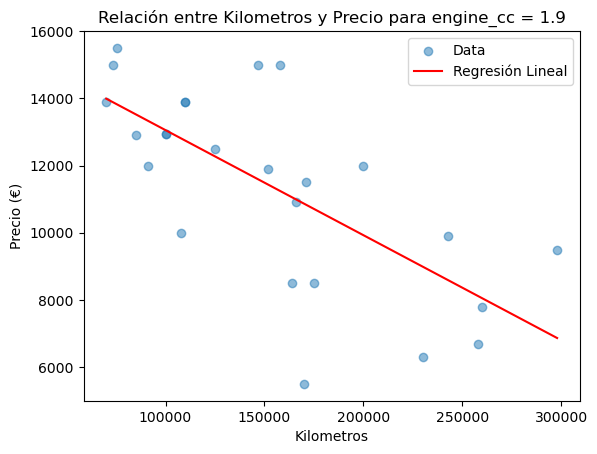

In [29]:

import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

def plot_kms_vs_price(df, engine_cc_filter):
    # Filtrar el DataFrame por el valor de 'engine_cc'
    filtered_df = df[df['engine_cc'] == engine_cc_filter]

    # Convertir las columnas 'kms' y 'price' a valores numéricos
    filtered_df['kms_numeric'] = filtered_df['kms'].str.replace(' km', '').str.replace('.', '').astype(float)
    filtered_df['price_numeric'] = filtered_df['price'].str.replace(' €', '').str.replace('.', '').astype(float)

    # Scatter plot de kms vs price
    plt.scatter(filtered_df['kms_numeric'], filtered_df['price_numeric'], alpha=0.5, label='Data')
    plt.xlabel('Kilometros')
    plt.ylabel('Precio (€)')
    plt.title(f'Relación entre Kilometros y Precio para engine_cc = {engine_cc_filter}')

    # Ajustar un modelo de regresión lineal
    X = filtered_df[['kms_numeric']].values
    y = filtered_df['price_numeric'].values
    model = LinearRegression()
    model.fit(X, y)

    # Graficar la línea de regresión
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    plt.plot(x_range, y_pred, color='red', label='Regresión Lineal')

    plt.legend()
    plt.show()

plot_kms_vs_price(df, 1.9)